# PRONTO heterogeneous benchmark dataset
The PRONTO heterogeneous benchmark dataset is based on an industrial-scale multiphase flow facility. It includes data from heterogeneous sources, including process measurements, alarm records, high frequency ultrasonic flow and pressure measurements, an operation log and video recordings. The study collected data from various operational conditions with and without induced faults to generate a multi-rate, multi-modal dataset. The dataset is suitable for developing and validating algorithms for fault detection and diagnosis (FDD) and data fusion. 

Data type|Sampling rate|Storage policy
:---:|:---:|:---:
Process measurements|1Hz|Regularly sampled
Alarm, event, change logs|Event-driven|Discrete events
Ultrasonic flow measurements|10 kHz|60 s recordings
High frequency pressure measurements|5 kHz|60 s recordings
Videos|–|30–60 s recordings

Preprocessed data are available here: ../data/

Full dataset: https://zenodo.org/record/1341583#.YaX52cfP23B

Publication: https://www.sciencedirect.com/science/article/pii/S0959152418303603#bib0035

Loading pre-processed data.

Pre-processing is done to align and label alarm and process data:
* Extract binary features from the alarm data:
    FIC301,FIC302,LI405,LI502,PT312,VC303,VC401,VC403,VC404,VC405,VC406,VLV303 are present in the the alarm logs
    Each alarm log contains the timestamp, the corresponding sensor tag and status information, whether they are 
    active or inactive. The alarm log entires are transformed into a binary form: 
    The binary alarm value of alarm Aik is 0 if no active Ai for timestamp k and no previous active Ai; or latest Ai was inactive.
    The binary alarm value of alarm Aik is 1 if no active Ai for timestamp k and latest Ai was active; or active Ai for timestamp k.
    See output files: alarmsfault07092017_proc.csv, alarmsonly11092017_proc.csv, alarmsonly12092017_proc.csv

* Order alarms in historical orders from least recent to most recent. (The alarm log contains entries with decreasing time stamps)

* Merge alarm and process data by timestamp

* Create one input water and air flow rate column based on the opeartion log

* Label data by health condition based on the opertion log

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
# Auto Associative Kernel Regression
from aakr import AAKR
# PCA and PCR
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
# SVM
from sklearn import svm

In [44]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [45]:
# Test day 2 (Fault: Air Blockage Test2, Test3 & Air Leakage Test4)
df1 = pd.read_csv("..\\data\\Testday2_merged.csv", sep = ",")
df1.head()

,FIC301,FIC302,LI405,LI502,PT312,VC303,VC401,VC403,VC404,VC405,...,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level,Fault
0,0,0,1,0,0,0,0,0,0,0,...,1.027175,0.000491,0.064845,1.005916,25.092310,62.243111,98.642677,2.257356,1.443121,Normal
1,0,0,1,0,0,0,0,0,0,0,...,1.027277,0.000483,0.095639,1.006192,25.099390,62.235279,98.644371,2.278575,1.443152,Normal
2,0,0,1,0,0,0,0,0,0,0,...,1.028881,0.000476,0.095639,1.006467,25.106461,62.227440,98.646057,2.299793,1.443183,Normal
3,0,0,1,0,0,0,0,0,0,0,...,1.028640,0.000468,0.076789,1.006743,25.113529,62.219608,98.647758,2.321012,1.443214,Normal
4,0,0,1,0,0,0,0,0,0,0,...,1.028400,0.000461,0.076789,1.006743,25.120600,62.262520,98.649452,2.399387,1.443244,Normal


In [46]:
# Test day 3 (Fault: Air Leakage Test5, Test6 & Diverted Flow Test7, Test8)
df2 = pd.read_csv("..\\data\\Testday3_merged.csv", sep = ",")
df2.head()

,FIC301,FIC302,LI405,LI505,PT312,VC303,VC401,VC403,VC404,VC405,...,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level,Fault
0,0,0,0,0,0,0,0,0,0,0,...,1.024576,0.090642,0.063302,1.004279,24.913710,61.413651,98.675041,0.162422,1.447658,Normal
1,0,0,0,0,0,0,0,0,0,0,...,1.024435,0.090642,0.072116,1.004258,24.917240,61.425671,98.671982,0.169636,1.447643,Normal
2,0,0,0,0,0,0,0,0,0,0,...,1.024295,0.061328,0.080931,1.004238,24.920759,61.440929,98.668907,0.176850,1.447628,Normal
3,0,0,0,0,0,0,0,0,0,0,...,1.024155,0.061328,0.082854,1.004217,24.924290,61.456188,98.665848,0.163235,1.447613,Normal
4,0,0,0,0,0,0,0,0,0,0,...,1.024014,0.040729,0.084776,1.004196,24.927820,61.471439,98.662781,0.149621,1.447598,Normal


In [47]:
# Test day 4 (Fault: Flow Conditions - Normal operating conditions Test9 + Slugging Test10)
df3 = pd.read_csv("..\\data\\Testday4_merged.csv", sep = ",")
df3.head()

,FIC301,FIC302,LI405,LI502,PT312,VC303,VC401,VC403,VC404,VC405,...,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level,Fault
0,0,0,1,0,0,0,0,0,0,0,...,1.019359,0.000280,0.0,0.998123,15.60613,53.431370,98.613892,0.0,1.444376,Slugging
1,0,0,1,0,0,0,0,0,0,0,...,1.019469,0.000266,0.0,0.998133,15.60219,53.397991,98.614326,0.0,1.444363,Slugging
2,0,0,1,0,0,0,0,0,0,0,...,1.019580,0.000252,0.0,0.998142,15.59825,53.399811,98.614754,0.0,1.444349,Slugging
3,0,0,1,0,0,0,0,0,0,0,...,1.019690,0.000238,0.0,0.998152,15.59431,53.401642,98.615189,0.0,1.444335,Slugging
4,0,0,1,0,0,0,0,0,0,0,...,1.019800,0.000224,0.0,0.998161,15.59037,53.403461,98.615623,0.0,1.444322,Slugging


In [6]:
# Merge three datasets

df = pd.concat([df1, df2, df3], ignore_index=True, sort=False)
df = df.dropna(axis='columns')

df

,FIC301,FIC302,LI405,PT312,VC303,VC401,VC403,VC404,VC405,VC406,...,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level,Fault
0,0,0,1,0,0,0,0,0,0,0,...,1.027175,0.000491,0.064845,1.005916,25.092310,62.243111,98.642677,2.257356,1.443121,Normal
1,0,0,1,0,0,0,0,0,0,0,...,1.027277,0.000483,0.095639,1.006192,25.099390,62.235279,98.644371,2.278575,1.443152,Normal
2,0,0,1,0,0,0,0,0,0,0,...,1.028881,0.000476,0.095639,1.006467,25.106461,62.227440,98.646057,2.299793,1.443183,Normal
3,0,0,1,0,0,0,0,0,0,0,...,1.028640,0.000468,0.076789,1.006743,25.113529,62.219608,98.647758,2.321012,1.443214,Normal
4,0,0,1,0,0,0,0,0,0,0,...,1.028400,0.000461,0.076789,1.006743,25.120600,62.262520,98.649452,2.399387,1.443244,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33715,0,0,1,0,0,0,0,0,0,0,...,1.023186,8.724998,1.406998,0.999428,27.505890,61.930328,98.402184,7.785863,1.423562,Diverted flow
33716,0,0,1,0,0,0,0,0,0,0,...,1.023179,9.239656,1.213346,0.999405,27.502741,61.876289,98.401901,7.723396,1.423599,Diverted flow
33717,0,0,1,0,0,0,0,0,0,0,...,1.023171,9.239656,1.136754,0.999382,27.499590,62.095631,98.401627,7.660929,1.423636,Diverted flow
33718,0,0,1,0,0,0,0,0,0,0,...,1.023163,9.012890,1.126894,0.999359,27.496429,62.056889,98.401352,7.879085,1.423673,Diverted flow


In [86]:
# Types of faults and appropriate number of records
df.groupby(['Fault'])['FIC301'].count()

Fault
Air blockage      8880
Air leakage       8279
Diverted flow    11519
Normal           11899
Slugging          4843
Name: FIC301, dtype: int64

In [87]:
df.describe()

,FIC301,FIC302,LI405,PT312,VC303,VC401,VC403,VC404,VC405,VC406,...,riser.outlet.P,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level
count,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.0,45420.0,45420.0,45420.0,45420.0,...,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000
mean,0.071180,0.062241,0.679018,0.163804,0.002576,0.0,0.0,0.0,0.0,0.0,...,1.109878,1.019045,3.358363,0.559113,0.997311,22.352009,61.782958,98.623634,9.275199,1.426527
std,0.257128,0.241596,0.466859,0.370102,0.050689,0.0,0.0,0.0,0.0,0.0,...,0.165797,0.030180,5.135456,0.567385,0.029712,7.369957,1.457677,0.173581,11.556427,0.012909
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.820029,0.845333,0.000000,-4.607517,0.822942,0.030689,49.623772,97.675377,0.000000,1.388638
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.014582,1.017692,0.000414,0.070511,0.996003,20.038310,61.755878,98.549589,2.283776,1.419087
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.037709,1.021233,0.043302,0.397561,0.999314,25.058850,61.981190,98.664036,6.556579,1.425808
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.153582,1.024938,6.983966,0.942655,1.002923,27.315350,62.153648,98.712509,8.254080,1.439326
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,...,3.183747,1.328773,43.850960,2.840868,1.307652,34.459080,75.759613,99.930847,56.039059,1.448196


## Dataset visualisation

In [9]:
xcoords = [0, 361, 9241, 9602, 12420, 13320, 16201, 17821, 20401, 21721, 29041, 29521, 33720, 35279, 37260, 38264, 41034, 43314, 45420]
xvalues = ['Normal','Air blockage', 'Normal', 'Air leakage', 'Normal', 'Air leakage', 'Normal', 'Air leakage', 'Normal',
           'Diverted flow', 'Normal', 'Diverted flow', 'Slugging', 'Normal', 'Slugging', 'Normal', 'Slugging', 'Normal','Normal']

def plot_time_series_measurements(df, xcoords, xvalues):
    plt.style.use("fivethirtyeight")
    fig, axs = plt.subplots(df.shape[1], 1, figsize=(12, 30), sharex=True)
    i = 0
    for (columnName, columnData) in df.iteritems():
        axs[i].plot(columnData, color='grey', label=columnName)
        axs[i].legend()
        axs[i].grid(True)
        for x in range(len(xcoords)-1):
            if xvalues[x]=='Normal':
                color_val = 'g'
            else:
                color_val = 'r'
            axs[i].axvspan(xcoords[x], xcoords[x+1]-1, facecolor=color_val, alpha=0.3)
            axs[i].axvline(x=xcoords[x], color=color_val,lw=1, linestyle='dashed')
        
        axs[i].set_xticks(xcoords[0:len(xcoords)-1])
        axs[i].set_xticklabels(xvalues[0:len(xcoords)-1], rotation = 30, fontsize=8)
        i +=1
    plt.show()

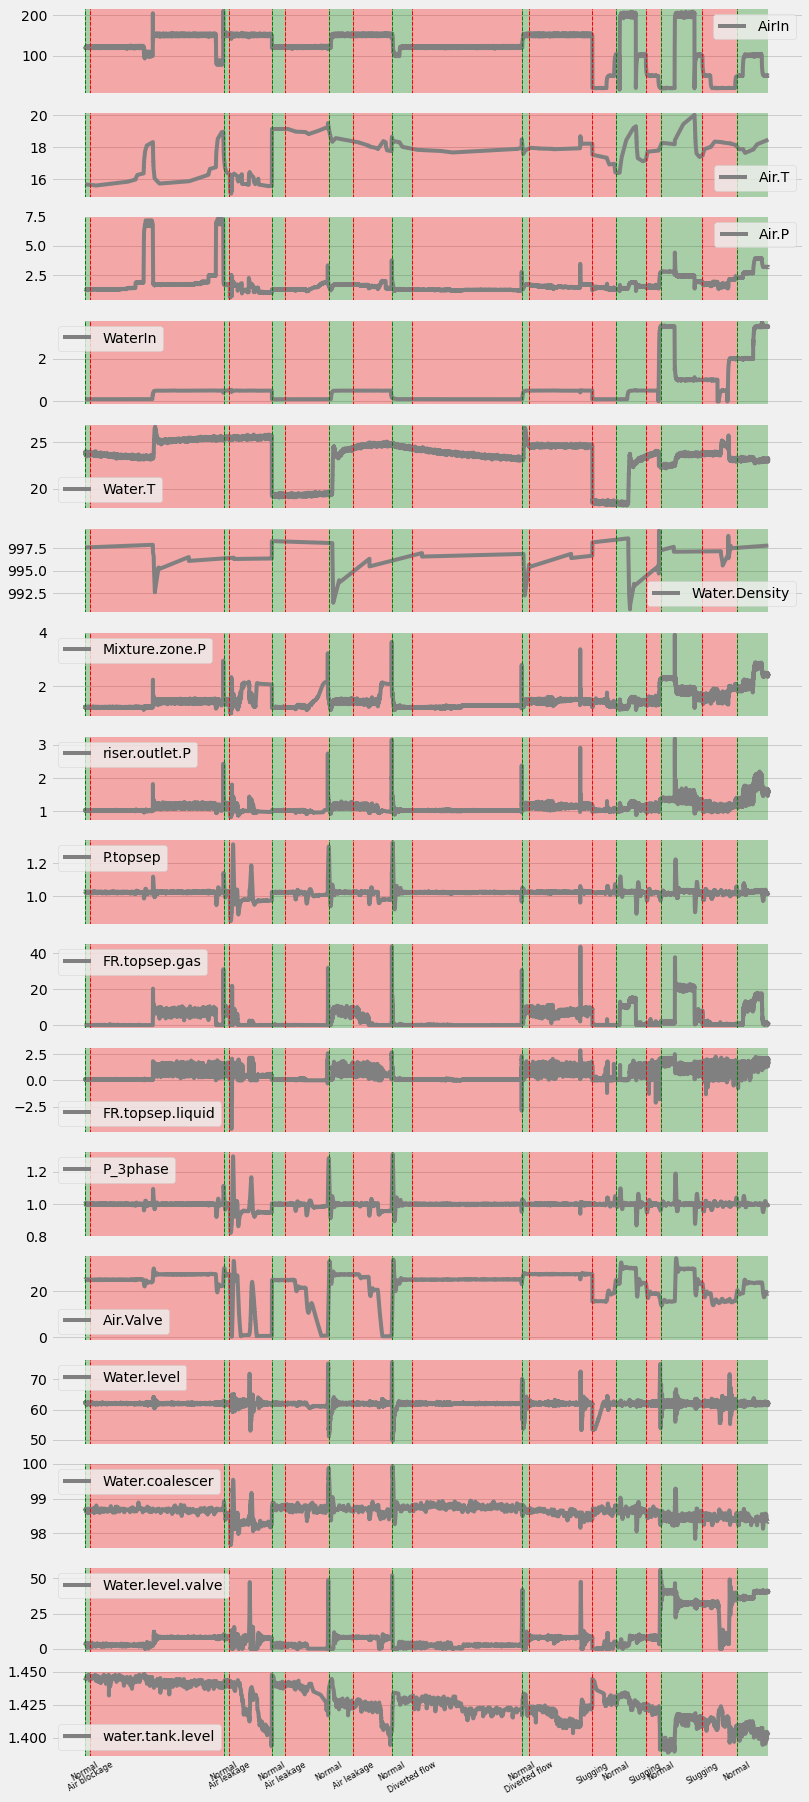

In [10]:
# Visualise without alarms (0:10) and Fault column (29)
plot_time_series_measurements(df.iloc[:,11:28],xcoords,xvalues)

## Data stationarity
Stationarity implies that taking consecutive samples of data with the same size should have identical covariances regardless of the starting point.

A time series is stationary if it satisfies the following three conditions.

* Mean of the series over time is constant
* Variance of the series over time is constant.
* No seasonality.

We would like to make sure that all columns are stationary.

In [89]:
def check_if_not_stationary(X):
    output = []
    for (columnName, columnData) in X.iteritems():
        #perform augmented Dickey-Fuller test
        res = adfuller(columnData)[1]
        res_boolean = True if res>=0.05 else False
        output.append(res_boolean)
    return output

In [90]:
# Add False for the first 11 alarms and calculate stationary values for measurement columns
not_stationary =  [False for i in range(11)] + check_if_not_stationary(df.iloc[:,11:28])
# Add False for the Fault column
not_stationary.append(False)

In [91]:
# Not stationary measurement columns according to Dickey-Fuller test
df.iloc[:,not_stationary]

,Air.T,WaterIn
0,15.681660,0.096309
1,15.681560,0.096320
2,15.681470,0.096331
3,15.681380,0.096342
4,15.681290,0.096354
...,...,...
45415,18.470489,3.490162
45416,18.470881,3.491043
45417,18.471270,3.491924
45418,18.471649,3.492805


## Transform not stationary columns

In [92]:
# 1st difference method to transform not stationary columns
df.iloc[:,not_stationary].diff().fillna(0)

,Air.T,WaterIn
0,0.000000,0.000000
1,-0.000100,0.000011
2,-0.000090,0.000011
3,-0.000090,0.000011
4,-0.000091,0.000011
...,...,...
45415,0.000389,-0.003243
45416,0.000391,0.000881
45417,0.000389,0.000881
45418,0.000380,0.000881


In [15]:
# Check if 1st difference helped
not_stationary2 = check_if_not_stationary(df.iloc[:,not_stationary].diff().fillna(0))
not_stationary2

[False, False]

In [93]:
# Replace not stationary measurements with their 1st differences
df_diff = df
new_values = df_diff.iloc[:,not_stationary].diff().fillna(0)
df_diff[list(df_diff.iloc[:,not_stationary].columns)] = new_values

## Split data into train and test datasets

Time Series Split is a special variation of k fold cross-validation to validate time series data samples, observed at fixed time intervals. 
It returns first k folds as train set and the (k+1) th set as test set. Unlike conventional k fold cross-validation methods, successive training sets are supersets of those that come before them. It also adds all surplus data to the first training set that is always used to train the model.

In [17]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(df_diff):
    X_train, X_test = df_diff.iloc[train_index,:], df_diff.iloc[test_index,:]
    X_normal = X_train[X_train['Fault'] == 'Normal']
    print('TRAIN:', len(train_index), 'TEST:', len(test_index),'NORMAL:', len(X_normal))

TRAIN: 7570 TEST: 7570 NORMAL: 361
TRAIN: 15140 TEST: 7570 NORMAL: 1622
TRAIN: 22710 TEST: 7570 NORMAL: 4562
TRAIN: 30280 TEST: 7570 NORMAL: 5042
TRAIN: 37850 TEST: 7570 NORMAL: 7023


## Baseline model - Auto Associative Kernel Regression (AAKR)
https://github.com/jmyrberg/aakr

In [107]:
def model_metrics_confusion_matrix(y_actual, y_predicted):
    # Confusion matrix
    y_actual_pd = pd.Series(y_actual, name='Actual')
    y_predicted_pd = pd.Series(y_predicted, name='Predicted')
    printmd("**Confusion matrix**")
    print(pd.crosstab(y_actual_pd, y_predicted_pd, margins = True))

In [108]:
def model_metrics_others(y_actual, y_predicted, number_of_digits = 2):
    # Precision and recall
    # Precision is the ratio between the True Positives and all the points that are classified as Positives. 
    # Precision = TP/(TP + FP)
    precision = precision_score(y_actual, y_predicted)
    # Recall is the measure of our model correctly identifying True Positives.
    # Recall = TP/(TP + FN)
    recall = recall_score(y_actual, y_predicted)
    accuracy = accuracy_score(y_actual, y_predicted)
    f1 = f1_score(y_actual, y_predicted)
    return [str(round(precision,number_of_digits)),
                str(round(recall,number_of_digits)),
                str(round(accuracy,number_of_digits)),
                str(round(f1,number_of_digits))]

In [109]:
def model_metrics_others_print(values):
    print ("{:<10} {:<10} {:<10} {:<10} {:<10}".format('Fold','Precision','Recall','Accuracy','F1'))
    i = 1
    for v in values:
        precision, recall, accuracy, f1 = v
        print ("{:<10} {:<10} {:<10} {:<10} {:<10}".format(i ,precision, recall, accuracy, f1))
        i += 1
    df = pd.DataFrame(values, columns=['Precision','Recall','Accuracy','F1'])
    df['Precision']=pd.to_numeric(df.Precision)
    df['Recall']=pd.to_numeric(df.Recall)
    df['Accuracy']=pd.to_numeric(df.Accuracy)
    df['F1']=pd.to_numeric(df.F1)
    precision, recall, accuracy, f1 = list(df.mean())
    print ("{:<10} {:<10} {:<10} {:<10} {:<10}".format('Average' ,round(precision,2), round(recall,2), 
                                                       round(accuracy,2), round(f1,2)))

In [110]:
def model_metrics_others_print_simple(values, number_of_digits = 2):
    precision, recall, accuracy, f1 = values
    printmd("**Model Metrics**")
    print ("{:<10} {:<10} {:<10} {:<10}".format('Precision','Recall','Accuracy','F1'))
    print ("{:<10} {:<10} {:<10} {:<10}".format(round(float(precision),number_of_digits), 
                                                round(float(recall),number_of_digits), 
                                                            round(float(accuracy),number_of_digits), 
                                                                        round(float(f1),number_of_digits)))

In [22]:
diff_models_results = []
# Binary alarms
alarms = ['FIC301', 'FIC302', 'LI405', 'LI502', 'LI505', 'PT312', 'VC303', 'VC401', 'VC403', 'VC404', 'VC405', 'VC406', 'VLV303']
# AAKR model
aakr = AAKR() 
sigma = 0.6
y_test_sum = []
y_predicted_sum = []
results = []

for train_index, test_index in tscv.split(df_diff):
    X_train, X_test = df_diff.iloc[train_index,:], df_diff.iloc[test_index,:]
    X_test = X_test.reset_index(drop=True)
    X_normal = X_train[X_train['Fault'] == 'Normal'].reset_index(drop=True)
    
    # Actual fault values
    y_test = X_test['Fault'].replace(['Diverted flow','Air blockage','Air leakage','Slugging','Normal'], [1, 1, 1, 1, 0])
    y_train = X_train['Fault'].replace(['Diverted flow','Air blockage','Air leakage','Slugging','Normal'], [1, 1, 1, 1, 0])
    
    # Predicted fault values
    ############################
    # Fit normal data into AAKR
    aakr.partial_fit(X_normal.iloc[:, :-1])
    # Find "normal" predicted measurements for test data
    X_aakr = pd.DataFrame(aakr.transform(X_test.iloc[:, :-1]), columns = X_test.iloc[:, :-1].columns)
    
    # Predict fault status for the measurement 
    # detecting if measurement is outside of the "normal" region:
    # more than 0.8 sd difference between "normal" AAKR predicted measurement (X_aakr) and observed measurement (X_test)
    for (columnName, columnData) in X_aakr.iteritems():
        if columnName not in alarms: # AAKR is not working with binary values
            X_aakr[columnName+"_Outside"] = np.where((abs(X_aakr[columnName]-X_test.iloc[:, :-1][columnName])<=sigma*X_normal.iloc[:, :-1][columnName].std()), False, True)
    # Predict fault status for the whole system if at least one measurement is outside of the "normal" region
    X_aakr["Predicted"] = np.where(X_aakr.loc[:, X_aakr.columns.str.contains('_Outside')].sum(axis=1)>0,True,False)
    y_predicted_aakr = X_aakr["Predicted"].replace([True, False], [1, 0])
    ############################
    y_predicted_sum = y_predicted_sum + list(y_predicted_aakr)
    y_test_sum = y_test_sum + list(y_test)
    results.append(model_metrics_others(y_test, y_predicted_aakr))
    
model_metrics_others_print(results)
model_metrics_confusion_matrix(y_test_sum, y_predicted_sum)

# Collect model metrics
result = model_metrics_others(y_test_sum, y_predicted_sum)
result.insert(0, 'AAKR')
diff_models_results.append(result)

Fold       Precision  Recall     Accuracy   F1        
1          0.83       1.0        0.83       0.91      
2          0.61       1.0        0.61       0.76      
3          0.94       0.99       0.93       0.96      
4          0.74       1.0        0.74       0.85      
5          0.36       1.0        0.36       0.52      
Average    0.7        1.0        0.69       0.8       


**Confusion matrix**

Predicted   0      1    All
Actual                     
0           5  11533  11538
1          80  26232  26312
All        85  37765  37850


## From here we will use normal train test split not the TimeSeriesSplit
It is needed to make sure that our records are good to predict fault outcome.

In [94]:
# Split into train and test sets replacing not stationary measurements with their 1st differences
rng = np.random.RandomState(0)
X_train, X_test = train_test_split(df_diff, random_state=rng)

# Actual fault values
y_test = X_test['Fault'].replace(['Diverted flow','Air blockage','Air leakage','Slugging','Normal'], [1, 1, 1, 1, 0])
y_train = X_train['Fault'].replace(['Diverted flow','Air blockage','Air leakage','Slugging','Normal'], [1, 1, 1, 1, 0])

## PCR model

In [24]:
def pcr_prediction(X_train, Y_train, X_test, PC_number = 2):
    pca = PCA()
    # PCA transform data using PC_number first PCs
    X_train_reduced =  pca.fit_transform(X_train)[:,:PC_number]
    X_test_reduced = pca.transform(X_test)[:,:PC_number] 
    
    # Train PCR model
    regr = LinearRegression()
    regr.fit(X_train_reduced, Y_train)
    
    # Predict outputs
    X_pcr = regr.predict(X_test_reduced)
    return np.array(list(map(lambda x: 1 if x>=0.5 else 0, X_pcr)))

In [25]:
PC_number = 4

# Predicted fault values using PCR
y_predicted_pcr = pcr_prediction(X_train.iloc[:, :-1], y_train, X_test.iloc[:, :-1], PC_number)

printmd("**PCR with Linear Regression:**")

model_metrics_confusion_matrix(y_test, y_predicted_pcr)

# Collect and print model metrics
result = model_metrics_others(y_test, y_predicted_pcr)
model_metrics_others_print_simple(result)
result.insert(0, 'PCR with Linear Regression')
diff_models_results.append(result)

**PCR with Linear Regression:**

**Confusion matrix**

Predicted    0     1   All
Actual                    
0           24   152   176
1          339  2360  2699
All        363  2512  2875


**Model Metrics**

Precision  Recall     Accuracy   F1        
0.82       0.97       0.83       0.89      


## PCR model with Logistic Binary Regression

In [26]:
def pcr_lr_prediction(X_train, Y_train, X_test, PC_number = 2):
    pca = PCA()
    # PCA transform data using PC_number first PCs
    X_train_reduced =  pca.fit_transform(X_train)[:,:PC_number]
    X_test_reduced = pca.transform(X_test)[:,:PC_number] 
    
    # Train PCR model
    logistic_regression_lr = LogisticRegression()
    lr_model = logistic_regression_lr.fit(X_train_reduced, Y_train)
    
    # Predict outputs
    y_predicted_pcr_lr = lr_model.predict(X_test_reduced)
    return y_predicted_pcr_lr

In [27]:
# Predicted fault values using PCR LR
y_predicted_pcr_lr = pcr_lr_prediction(X_train.iloc[:, :-1], y_train, X_test.iloc[:, :-1], PC_number)

printmd("**PCR with Logistic Binary Regression:**")

model_metrics_confusion_matrix(y_test, y_predicted_pcr_lr)

# Collect and print model metrics
result = model_metrics_others(y_test, y_predicted_pcr_lr)
model_metrics_others_print_simple(result)
result.insert(0, 'PCR with Logistic Binary Regression')
diff_models_results.append(result)

**PCR with Logistic Binary Regression:**

**Confusion matrix**

Predicted    0     1   All
Actual                    
0           25   151   176
1          360  2339  2699
All        385  2490  2875


**Model Metrics**

Precision  Recall     Accuracy   F1        
0.83       0.97       0.83       0.89      


## PCR model with Logistic Multiclass Regression

In [28]:
def pcr_mlr_prediction(X_train, Y_train, X_test, PC_number = 2):
    pca = PCA()
    # PCA transform data using PC_number first PCs
    X_train_reduced =  pca.fit_transform(X_train)[:,:PC_number]
    X_test_reduced = pca.transform(X_test)[:,:PC_number] 
    
    # Train PCR model
    # Create Multiclass LR model
    logistic_regression_mlr = LogisticRegression(multi_class="multinomial",penalty="l2",max_iter=int(1e6))
    mlr_model = logistic_regression_mlr.fit(X_train_reduced, y_train_mlr)
    
    # Predict outputs
    y_predicted_pcr_mlr = mlr_model.predict(X_test_reduced)
    return y_predicted_pcr_mlr

In [29]:
# Actual fault values
y_train_mlr = X_train['Fault'] 
y_test_mlr = X_test['Fault']    

# Predicted fault values using PCR MLR
y_predicted_pcr_mlr = pcr_mlr_prediction(X_train.iloc[:, :-1], y_train_mlr, X_test.iloc[:, :-1], PC_number)

printmd("**PCR with Logistic Multiclass Regression:**")

model_metrics_confusion_matrix(y_test_mlr, y_predicted_pcr_mlr)

# Collect and print model metrics
result = [precision_score(y_test_mlr,y_predicted_pcr_mlr, average="macro"),
          recall_score(y_test_mlr,y_predicted_pcr_mlr, average="macro"),
          accuracy_score(y_test_mlr,y_predicted_pcr_mlr),
          f1_score(y_test_mlr,y_predicted_pcr_mlr, average="macro")]

model_metrics_others_print_simple(result)
result.insert(0, 'PCR with Logistic Multiclass Regression')
diff_models_results.append(result)

**PCR with Logistic Multiclass Regression:**

**Confusion matrix**

Predicted     Air blockage  Air leakage  Diverted flow  Normal  Slugging   All
Actual                                                                        
Air blockage            94          356            925     606       245  2226
Air leakage             21           84            191     124        53   473
Normal                   5           27             76      46        22   176
All                    120          467           1192     776       320  2875


**Model Metrics**

Precision  Recall     Accuracy   F1        
0.65       0.63       0.61       0.61      


## Random Forest binary model

In [30]:
def rf_prediction(X_train, Y_train, X_test, random_state_value = 42):   
    # Train RF model
    rf = RandomForestClassifier(random_state = random_state_value)
    rf.fit(X_train, Y_train)
    
    # Predict outputs
    y_predicted_rf = rf.predict(X_test)
    return y_predicted_rf

In [31]:
# Predicted fault values using RF
y_predicted_rf = rf_prediction(X_train.iloc[:, :-1], y_train, X_test.iloc[:, :-1])

printmd("**Random Forest Binary Model:**")

model_metrics_confusion_matrix(y_test, y_predicted_rf)

# Collect and print model metrics
result = model_metrics_others(y_test, y_predicted_rf)
model_metrics_others_print_simple(result)
result.insert(0, 'Random Forest Binary Model')
diff_models_results.append(result)

**Random Forest Binary Model:**

**Confusion matrix**

Predicted    0     1   All
Actual                    
0           41   135   176
1          672  2027  2699
All        713  2162  2875


**Model Metrics**

Precision  Recall     Accuracy   F1        
1.0        1.0        1.0        1.0       


## Random Forest Multiclass Model

In [40]:
# Preprocessing
# Transforming non numerical labels into numerical labels
encoder = preprocessing.LabelEncoder()

# Encoding train labels 
encoder.fit(y_train_mlr)
y_train_encoded = encoder.transform(y_train_mlr)

# Encoding test labels 
encoder.fit(y_test_mlr)
y_test_encoded = encoder.transform(y_test_mlr)

# Scaling the Train and Test feature set 
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[:, :-1]), columns = X_train.iloc[:, :-1].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.iloc[:, :-1]) ,columns = X_test.iloc[:, :-1].columns)

In [72]:
def mrf_prediction(X_train, Y_train, X_test, random_state_value = 42):
    # Train RF model
    rf = RandomForestClassifier(random_state = random_state_value)
    rf.fit(X_train, Y_train);
    
    # Predict outputs
    y_predicted_mrf = rf.predict(X_test)
    
    # feature importance scores
    importances = rf.feature_importances_
    sorted_indices = np.argsort(importances[importances>0])[::-1]
    plt.title('Feature Importance')
    plt.bar(range(len(importances[importances>0])), importances[importances>0][sorted_indices], align='center')
    plt.xticks(range(len(importances[importances>0])), X_train_scaled.columns[importances>0][sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    return y_predicted_mrf

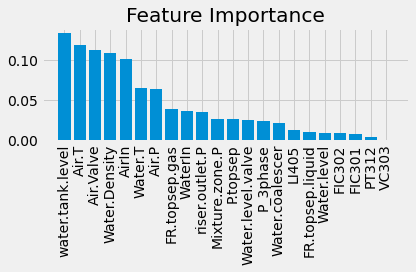

**Random Forest Multiclass Model:**

**Confusion matrix**

Predicted     Air blockage  Air leakage  Diverted flow  Normal  Slugging   All
Actual                                                                        
Air blockage           432          414            578     558       244  2226
Air leakage             89          101            115     114        54   473
Normal                  36           32             48      41        19   176
All                    557          547            741     713       317  2875
               precision    recall  f1-score   support

 Air blockage       1.00      1.00      1.00      2226
  Air leakage       1.00      1.00      1.00      2060
Diverted flow       1.00      1.00      1.00      2862
       Normal       1.00      1.00      1.00      3024
     Slugging       1.00      1.00      1.00      1183

     accuracy                           1.00     11355
    macro avg       1.00      1.00      1.00     11355
 weighted avg       1.00      1.00      1.00     11355



**Model Metrics**

Precision  Recall     Accuracy   F1        
1.0        1.0        1.0        1.0       


In [74]:
# Predicted fault values using MRF
y_predicted_mrf = mrf_prediction(X_train_scaled, y_train_mlr, X_test_scaled)

printmd("**Random Forest Multiclass Model:**")

model_metrics_confusion_matrix(y_test_mlr, y_predicted_mrf)
print(classification_report(y_test_mlr, y_predicted_mrf))

# Collect and print model metrics
result = [precision_score(y_test_mlr,y_predicted_mrf, average="macro"),
          recall_score(y_test_mlr,y_predicted_mrf, average="macro"),
          accuracy_score(y_test_mlr,y_predicted_mrf),
          f1_score(y_test_mlr,y_predicted_mrf, average="macro")]
model_metrics_others_print_simple(result)
result.insert(0, 'Random Forest Multiclass Model')
diff_models_results.append(result)

## Support Vector Machines

In [75]:
def svm_prediction(X_train, Y_train, X_test, encoder):
    # Train SVM model
    svm_model = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, Y_train)
    #poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, Y_train)
    
    # Predict outputs
    y_predicted_svm = svm_model.predict(X_test)    
    y_predicted_svm = y_predicted_svm.astype(int)
    y_predicted_svm_label = list(encoder.inverse_transform(y_predicted_svm))

    return y_predicted_svm_label

In [76]:
# Predicted fault values using SVM
y_predicted_svm = svm_prediction(X_train_scaled, y_train_encoded, X_test_scaled, encoder)

printmd("**SVM RBF Kernel Model:**")

model_metrics_confusion_matrix(y_test_mlr, y_predicted_svm)

# Collect and print model metrics
result = [precision_score(y_test_mlr,y_predicted_svm, average="macro"),
          recall_score(y_test_mlr,y_predicted_svm, average="macro"),
          accuracy_score(y_test_mlr,y_predicted_svm),
          f1_score(y_test_mlr,y_predicted_svm, average="macro")]
model_metrics_others_print_simple(result)
result.insert(0, 'SVM RBF Kernel Model')
diff_models_results.append(result)

**SVM RBF Kernel Model:**

**Confusion matrix**

Predicted     Air blockage  Air leakage  Diverted flow  Normal  Slugging   All
Actual                                                                        
Air blockage           437          391            579     587       232  2226
Air leakage             93           94            117     116        53   473
Normal                  36           29             48      47        16   176
All                    566          514            744     750       301  2875


**Model Metrics**

Precision  Recall     Accuracy   F1        
0.97       0.96       0.97       0.97      


## All models together

In [77]:
print ("{:<40} {:<10} {:<10} {:<10} {:<10}".format('Model','Precision','Recall','Accuracy','F1'))
for v in diff_models_results:
    model, precision, recall, accuracy, f1 = v
    print ("{:<40} {:<10} {:<10} {:<10} {:<10}".format(model ,round(float(precision),2), round(float(recall),2), 
                                                       round(float(accuracy),2), round(float(f1),2)))

Model                                    Precision  Recall     Accuracy   F1        
AAKR                                     0.69       1.0        0.69       0.82      
PCR with Linear Regression               0.82       0.97       0.83       0.89      
PCR with Logistic Binary Regression      0.83       0.97       0.83       0.89      
PCR with Logistic Multiclass Regression  0.65       0.63       0.61       0.61      
Random Forest Binary Model               1.0        1.0        1.0        1.0       
Random Forest Multiclass Model           1.0        1.0        1.0        1.0       
SVM RBF Kernel Model                     0.97       0.96       0.97       0.97      


## PRONTO publication approaches: 
* PCA-enhanced CVA 
* Bayesian 

In [48]:
df = pd.concat([df1, df2], ignore_index=True, sort=False)
df = df.dropna(axis='columns')
df = df.iloc[:,11:29] # removing alarms

In [49]:
# Due to the compression and quantization issues (???),
# the temperature and density measurements (FT305-T, FT102-T and FT102-D) are removed.
# FT305-T	Input air temperature	°C (Air.T)
# FT102-T	Input water temperature	°C (Water.T)
# FT102-D	Input water density	kg m−3 (Water.Density)
df = df.drop(['Air.T','Water.T','Water.Density'],axis=1) 

In [50]:
# Operating condition A: 120 Sm3 h−1 air, 0.1 kg s−1 water flow rates
# Operating condition B: 150 Sm3 h−1 air, 0.5 kg s−1 water flow rates.
airA = 120
air_sd = df['AirIn'].std()
airB = 150

waterA = 0.1
water_sd = df['WaterIn'].std()
waterB = 0.5

In [51]:
testA = df[(df['AirIn']<=airA+air_sd) & (df['AirIn']>=airA-air_sd) & (df['WaterIn']<=waterA+water_sd) & (df['WaterIn']>=waterA-water_sd)]
testA.describe()

,AirIn,Air.P,WaterIn,Mixture.zone.P,riser.outlet.P,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level
count,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000
mean,119.772820,1.383078,0.097545,1.281389,1.017945,1.021418,0.095771,0.071741,1.000189,23.307934,61.831026,98.731932,2.295955,1.432547
std,2.315698,0.594256,0.005135,0.171539,0.050719,0.023610,1.209138,0.108823,0.023521,5.540345,1.142167,0.101725,2.687068,0.009571
min,102.966904,1.138369,0.091159,1.129860,0.920644,0.929620,0.000000,-2.879891,0.907659,0.473675,50.160221,98.352493,0.000000,1.413100
25%,118.931702,1.249580,0.095132,1.218456,1.010767,1.018300,0.000163,0.053559,0.997247,24.900022,61.769755,98.686327,1.398820,1.422634
50%,119.518204,1.276749,0.097175,1.229317,1.016489,1.020608,0.000375,0.068358,0.999314,25.061510,61.976429,98.718483,2.332684,1.430387
75%,120.619698,1.296556,0.099599,1.283959,1.021973,1.023461,0.001196,0.081438,1.002459,25.150372,62.124600,98.769920,2.946758,1.441751
max,137.027893,7.138096,0.243839,3.229707,2.732414,1.324794,31.880859,2.563764,1.303609,33.817669,75.299454,99.876007,48.951672,1.447881


In [52]:
testB = df[(df['AirIn']<=airB+air_sd) & (df['AirIn']>=airB-air_sd) & (df['WaterIn']<=waterB+water_sd) & (df['WaterIn']>=waterB-water_sd)]
testB.describe()

,AirIn,Air.P,WaterIn,Mixture.zone.P,riser.outlet.P,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level
count,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000
mean,149.949050,1.618649,0.496727,1.538002,1.113941,1.014170,5.507931,0.747982,0.991804,22.222423,61.857720,98.583863,7.421933,1.427155
std,2.084516,0.300978,0.013942,0.240872,0.089169,0.035203,3.652627,0.369621,0.034533,9.897779,1.240844,0.182677,3.462573,0.011996
min,133.017700,0.607549,0.300948,0.997974,0.820029,0.845333,0.000000,-4.607517,0.822942,0.030689,52.973598,97.675377,0.000000,1.393454
25%,148.381607,1.495869,0.496354,1.418648,1.078241,1.016609,1.496053,0.513504,0.994343,24.551280,61.832094,98.533588,7.421128,1.420514
50%,149.278107,1.674486,0.497705,1.455840,1.130932,1.021603,6.834418,0.717526,0.998893,27.343081,61.993111,98.632072,7.970311,1.425116
75%,151.538300,1.712556,0.499793,1.505571,1.163119,1.025204,7.987027,0.969553,1.002390,27.463650,62.127424,98.686626,8.229408,1.440040
max,157.742004,6.604678,0.528756,3.377301,2.905509,1.316939,43.671860,2.840868,1.294650,33.269218,72.624359,99.537453,47.577122,1.445096


In [515]:
# Attempt to replicate publication results
# Operating condition A - testA
# Operating condition B - testB
# A fault is defined to be detected once at least one of the monitoring statistics 
# exceeds its control limit for more than 20 samples.

# Split into train and test sets
rng = np.random.RandomState(0)
X_train, X_test = train_test_split(testA, random_state=rng, train_size=0.9)
X_train = X_train[X_train['Fault']=='Normal'].iloc[:, :-1]
y_test = X_test['Fault']
X_test = X_test.iloc[:, :-1]

In [516]:
print(X_train.shape)
print(X_test.shape)

(2156, 14)
(1631, 14)


## Nice plots

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_train, y_train)

In [55]:
lda.explained_variance_ratio_

array([0.67274218, 0.30750058, 0.01975724])

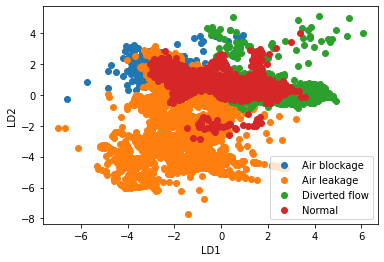

In [60]:
fig, ax = plt.subplots()
group = np.array(y_train)
plt.xlabel('LD1')
plt.ylabel('LD2')
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(X_lda[i,0], X_lda[i,1], label=g)
ax.legend()
plt.show()

## PCA - enhanced LDA (Linear Discriminant Analysis or Canonical Variate Analysis) 

In [89]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_train)
X_pca_test = pca.fit_transform(X_test)

In [90]:
pca.explained_variance_ratio_

array([0.78172068, 0.16819395, 0.033455  , 0.01079735, 0.00372179])

In [115]:
lda = LinearDiscriminantAnalysis()
X_pca_lda = lda.fit_transform(X_train, y_train)
X_pca_lda_test = lda.transform(X_test)
y_predicted = lda.predict(X_test)

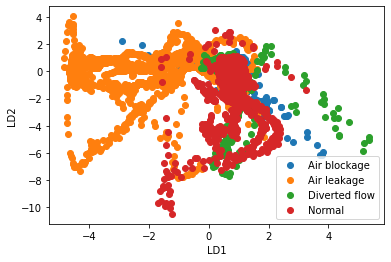

In [103]:
fig, ax = plt.subplots()
group = np.array(y_train)
plt.xlabel('LD1')
plt.ylabel('LD2')
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(X_pca_lda[i,0], X_pca_lda[i,1], label=g)
ax.legend()
plt.show()

In [104]:
# Monitoring statistics: the Hotelling's T2 statistic and the squared prediction error (SPE).


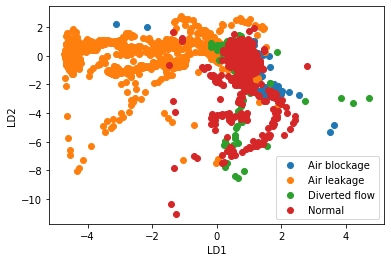

In [105]:
fig, ax = plt.subplots()
group = np.array(y_test)
plt.xlabel('LD1')
plt.ylabel('LD2')
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(X_pca_lda_test[i,0], X_pca_lda_test[i,1], label=g)
ax.legend()
plt.show()

In [116]:
# Collect and print model metrics
result = [precision_score(y_test, y_predicted, average="macro"),
          recall_score(y_test, y_predicted, average="macro"),
          accuracy_score(y_test, y_predicted),
          f1_score(y_test, y_predicted, average="macro")]

model_metrics_others_print_simple(result)

model_metrics_confusion_matrix(y_test, y_predicted)

**Model Metrics**

Precision  Recall     Accuracy   F1        
0.82       0.79       0.84       0.79      


**Confusion matrix**

Predicted     Air blockage  Air leakage  Diverted flow  Normal   All
Actual                                                              
Air blockage           632          326            805     260  2023
Normal                  24           15             36       9    84
All                    656          341            841     269  2107


In [100]:
from sklearn.cluster import KMeans

pca = PCA(2)
 
#Transform the data
kdf = pca.fit_transform(X_train.iloc[:, :-1])

kmeans = KMeans(n_clusters = 3)
 
label = kmeans.fit_predict(kdf)
 
print(label)

[1 2 1 ... 0 0 2]


In [112]:
y_train.to_numpy()

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [111]:
np.append(kdf, y_train.to_numpy(), axis=1)
kdf

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 34065 and the array at index 1 has size 1

ValueError: 'c' argument has 34065 elements, which is inconsistent with 'x' and 'y' with size 4987.

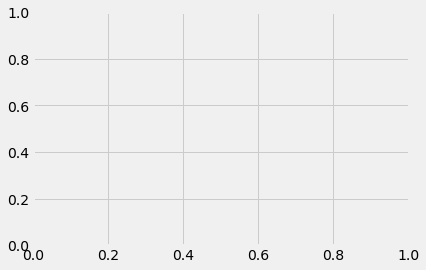

In [103]:
#Getting unique labels
 
u_labels = np.unique(label)

cmap = {'Normal': 'green', 'Air blockage': 'red', 'Air leakage':'red', 'Diverted flow':'red', 'Slugging': 'yellow'}

 
#plotting the results:
 
for i in u_labels:
    
    plt.scatter(kdf[label == i , 0] , kdf[label == i , 1] , c=[cmap.get(c, 'black') for c in y_train])
plt.legend()
plt.show()